In [1]:
#!pip install captum
#!pip install datasets
#!pip install flask
#!pip install flask-compress

# Loading Dataset 




In [2]:
from datasets import load_dataset

ds = load_dataset("pantelism/cats-vs-dogs")

Doing Necessary Imports :
* for transforming
* training model
* for the explainer algorithms
* for graph plotting

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image


import captum
from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


# Data PreProcessing

Resizing the images and performing transformation ,
Normalising based on standard ImageNet values

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization used in pre-training
])


In [5]:
X_input = ds['train']['image']
Y= ds['train']['label']

Getting X, Y tensors ready for training 

In [6]:
X_tensor = torch.stack([transform(image) for image in X_input])  # Convert images to tensors
Y_tensor = torch.tensor(Y, dtype=torch.float32)

In [7]:
from sklearn.model_selection import train_test_split
X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(
    X_tensor, Y_tensor, test_size=0.3, random_state=42
)

Creating Dataset and Loading to train_loader, test_loader

In [8]:
train_dataset = TensorDataset(X_train_split, Y_train_split)
test_dataset = TensorDataset(X_test_split, Y_test_split)

# Create DataLoaders for both training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model training

Training based on one of the less computation model - Resnet18 , tried defining CNN from scratch, but due to lot of time consumption with training, going with transfer leanring , commmenting the originally defined model

In [9]:

# class simpleCNN(nn.Module):
#   def __init__(self):
#     super(simpleCNN,self).__init__()
#     self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1,stride=1)
#     self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1,stride=1)
#     self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,stride=1)
#     #max pooling
#     self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
#     self.conv4=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,stride=1)
#     self.conv5=nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1,stride=1)
#     #max pooling
#     self.pool2=nn.MaxPool2d(kernel_size=2,stride=2,padding=0)

#     #Fully connected layers
#     self.fc1=nn.Linear(in_features=512*56*56, out_features=1024)
#     self.fc2=nn.Linear(in_features=1024, out_features=512)
#     self.fc3=nn.Linear(in_features=512, out_features=2)
#   def forward(self,x):
#     x=F.relu(self.conv1(x))
#     x=F.relu(self.conv2(x))
#     x=F.relu(self.conv3(x))
#     x=self.pool1(x)
#     x=F.relu(self.conv4(x))
#     x=F.relu(self.conv5(x))
#     print(x.shape)
#     x=self.pool2(x)
#     x=x.view(x.size(0),-1)
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     x = self.fc3(x)
#     return x



In [10]:
model = models.resnet18(pretrained=True)


/Users/debikad/Desktop/AI/eng-ai-agents/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/debikad/Desktop/AI/eng-ai-agents/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Freeze the feature extraction layers
for param in model.parameters():
    param.requires_grad = False

#fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Single output for binary classification


Defining Binary Cross Entropy for  binary classification and using adam Optimizer 

In [12]:

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


<b>Doing forward and backward pass to make model learn for the dataset </b>

In [13]:
num_epochs = 5  # Set the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs.squeeze(), labels)  # Compute BCE loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss /len(train_loader)}")

Epoch [1/5], Loss: 0.2890701359137893
Epoch [2/5], Loss: 0.14172924089838157
Epoch [3/5], Loss: 0.12206077812747522
Epoch [4/5], Loss: 0.10622918665070426
Epoch [5/5], Loss: 0.09287734295834195


# Model Evaluation 

Evaluating the model for train and test data

In [14]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for images, labels in train_loader:
        outputs = model(images)
        predicted = torch.round(torch.sigmoid(outputs.squeeze()))  # Sigmoid for binary output
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Train Accuracy: {accuracy:.4f}')

Train Accuracy: 0.9807


In [15]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for images, labels in test_loader:
        outputs = model(images)
        predicted = torch.round(torch.sigmoid(outputs.squeeze()))  # Sigmoid for binary output
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9708


# EXPLAINER ALGORITHM FOR CLASS 0 - CAT

In [16]:
sample_input, actual_label = test_dataset[1]
sample_input = sample_input.unsqueeze(0)
model.eval()
with torch.no_grad():
    output=model(sample_input)
    output = torch.sigmoid(output) 
# print(f"Model output values: {output}")
# print(f"output.item()  is:{output.item() }")
predicted_prob = output.item()
if (predicted_prob > 0.5):
    pred_label_idx=1
else:
    pred_label_idx=0

print(f"Actual Label: {actual_label.item()}")  
print(f"Predicted Label: {pred_label_idx}")  

target_tensor = pred_label_idx


Actual Label: 0.0
Predicted Label: 0


# Class 0 -Cat - Integrated Gradients

Calling the Integrated Gradients variable using Pytorch Captum , here 
* sample input is the image of cat
* target=0 because this is binary classification
* no of steps is 200 for the attributes
* Exception handling is included for debugging

In [17]:

integrated_gradients = IntegratedGradients(model)
try:
    attributions_ig = integrated_gradients.attribute(sample_input, target=0, n_steps=200)
    print("Attributions computed successfully.")
except Exception as e:
    print(f"Error during attribution computation: {e}")


print(f"Attributions: {attributions_ig}")

Attributions computed successfully.
Attributions: tensor([[[[-1.0492e-03, -1.7120e-05,  3.0136e-03,  ...,  2.9543e-03,
            9.0195e-03,  7.3933e-03],
          [-1.2486e-03, -1.2626e-03, -4.8299e-04,  ..., -6.3693e-03,
            3.2403e-04,  5.5942e-03],
          [-1.2857e-03, -3.8527e-03, -8.5481e-03,  ..., -1.4554e-02,
            3.1452e-03,  2.0423e-03],
          ...,
          [-1.3476e-03,  2.4655e-03,  4.7397e-03,  ..., -5.9599e-04,
           -1.0636e-03,  3.5843e-04],
          [ 4.3692e-03, -7.0388e-04,  9.7590e-04,  ..., -3.4991e-04,
           -4.1969e-04,  3.5806e-04],
          [ 8.0469e-03,  9.5819e-04, -3.9966e-03,  ..., -4.2333e-05,
            4.2325e-04,  4.4828e-04]],

         [[ 8.5998e-04,  1.9080e-03,  3.5092e-03,  ...,  3.9752e-03,
            1.8840e-02,  1.5173e-02],
          [ 5.1986e-04, -1.6063e-03, -5.0576e-03,  ..., -9.7240e-03,
            5.1731e-03,  9.0999e-03],
          [-1.6872e-04, -6.0967e-03, -1.7897e-02,  ..., -2.4607e-02,
        

# Visualisation of CAT Image(CLASS 0)  after using explainer algorithm - Integrated Gradient 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9876702..2.64].


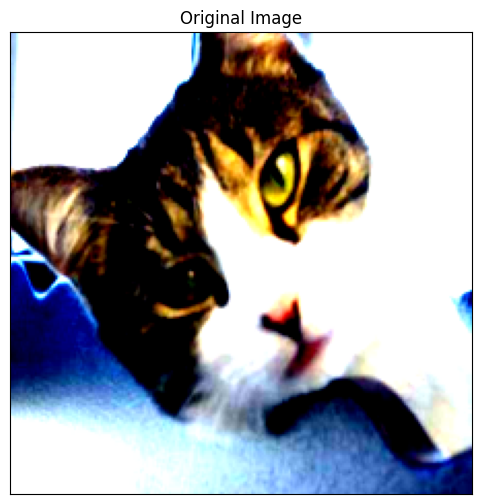

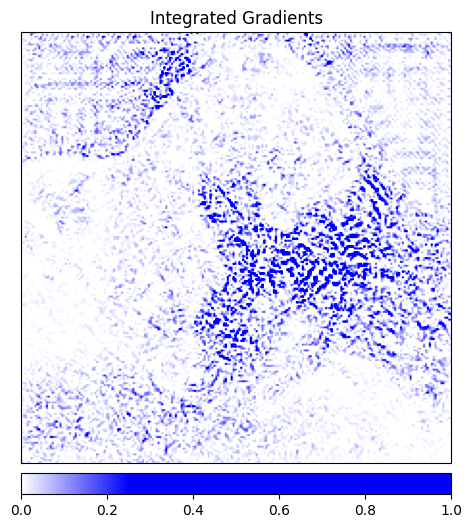

In [18]:
# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(sample_input.squeeze().cpu().detach().numpy(), (1,2,0)), 
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(sample_input.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

# CLASS 0 - CAT- GRADCAM

In [19]:

model.eval()
layers_to_visualize = [
    model.layer1[0].conv1,  
    model.layer1[1].conv2,  
    model.layer2[0].conv1,  
    model.layer2[1].conv2,  
    model.layer3[0].conv1,  
    model.layer3[1].conv2, 
    model.layer4[0].conv1,  
    model.layer4[1].conv2   
]

<Figure size 800x800 with 0 Axes>

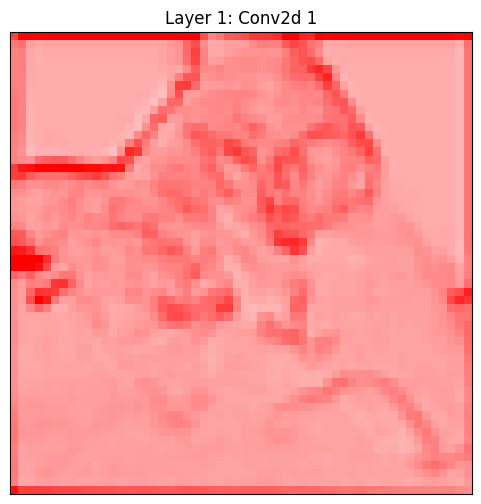

<Figure size 800x800 with 0 Axes>

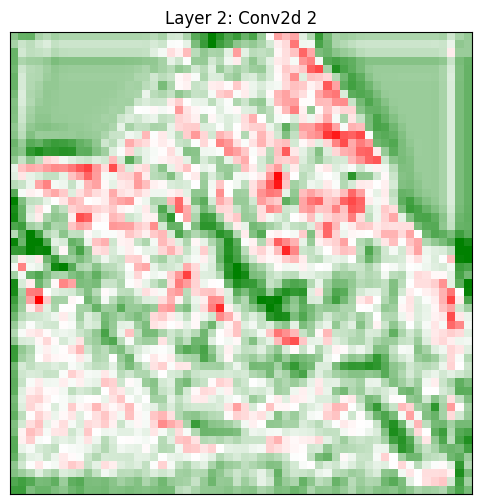

<Figure size 800x800 with 0 Axes>

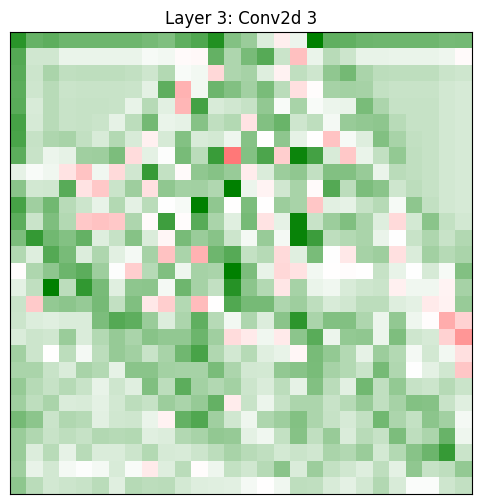

<Figure size 800x800 with 0 Axes>

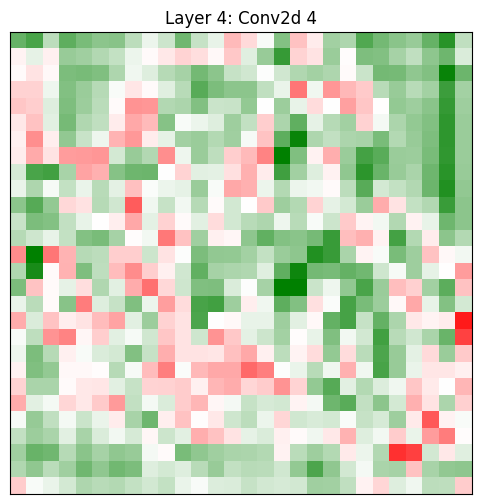

<Figure size 800x800 with 0 Axes>

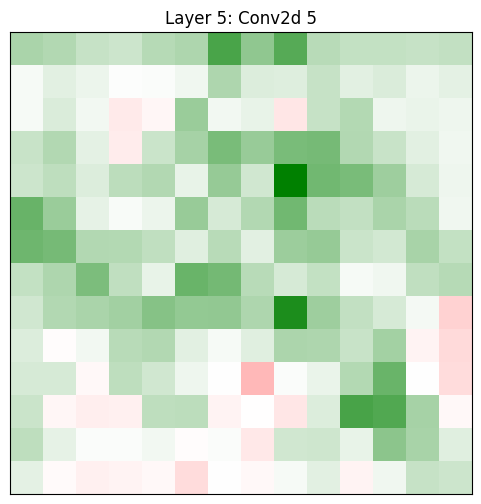

<Figure size 800x800 with 0 Axes>

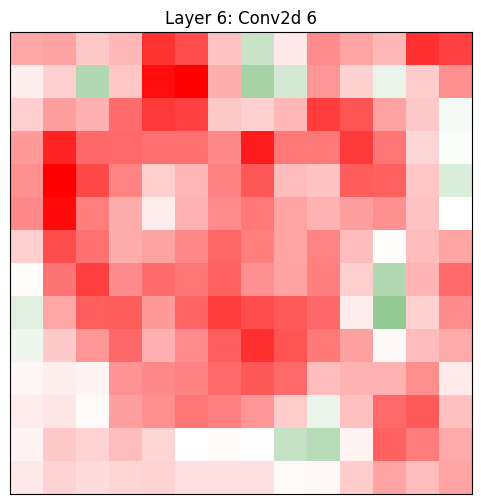

<Figure size 800x800 with 0 Axes>

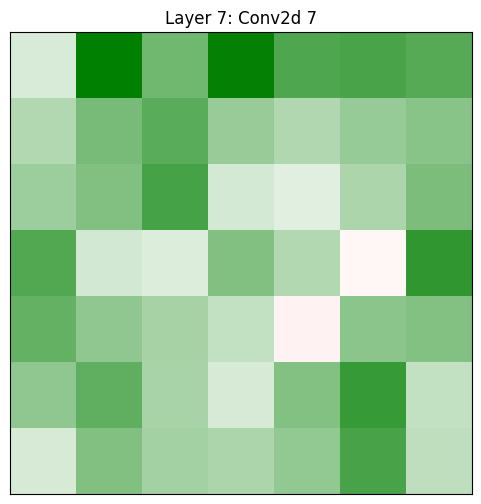

<Figure size 800x800 with 0 Axes>

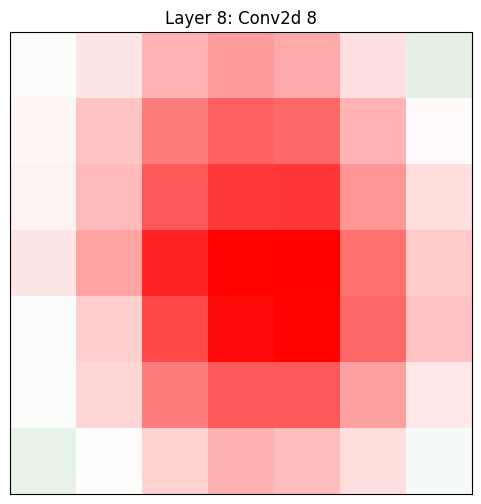

In [20]:

for i, layer in enumerate(layers_to_visualize):
    # Create LayerGradCam object for the current layer
    layer_gradcam = LayerGradCam(model, layer)
    attributions_lgc = layer_gradcam.attribute(sample_input, target=0)

    plt.figure(figsize=(8, 8))
    _ = viz.visualize_image_attr(
        attributions_lgc[0].cpu().permute(1, 2, 0).detach().numpy(),
        sign="all",
        title=f"Layer {i + 1}: {layer.__class__.__name__} {i + 1}"
    )
    plt.show()

<b>Ensure attributions_lgc has the correct number of channels</b>

In [21]:

if attributions_lgc.shape[1] == 1:  
    attributions_lgc = attributions_lgc.repeat(1, 3, 1, 1)  # Repeat the single channel 3 times to match RGB channels
elif attributions_lgc.shape[1] != 3:  # If it's not 1 or 3, this is unexpected
    raise ValueError(f"Unexpected number of channels in attributions_lgc: {attributions_lgc.shape[1]}")


<b>Upsample the attributions to match the spatial size of the input image</b>

In [22]:

upsamp_attr_lgc = F.interpolate(attributions_lgc, size=(224, 224), mode='bilinear', align_corners=False)

# Print shapes for debugging
print(f"Upsampled attributions shape: {upsamp_attr_lgc.shape}")  # Should be [1, 3, 224, 224]
print(f"Sample input shape: {sample_input.shape}")  # Should be [3, 224, 224]


Upsampled attributions shape: torch.Size([1, 3, 224, 224])
Sample input shape: torch.Size([1, 3, 224, 224])


<b>Ensure the sample input shape is correct; if not, we might need to unsqueeze it,
Then visualising the attributions</b>

In [23]:
import matplotlib.pyplot as plt
import numpy as np


if upsamp_attr_lgc.dim() == 4:  # [N, C, H, W]
    upsamp_attr_lgc = upsamp_attr_lgc.squeeze(0)  # Shape: [C, H, W]
if sample_input.dim() == 4:  # [N, C, H, W]
    sample_input = sample_input.squeeze(0)  # Shape: [C, H, W]

attribution_values = upsamp_attr_lgc.cpu().detach().numpy()
print(f'Min value in attribution map: {np.min(attribution_values)}')
print(f'Max value in attribution map: {np.max(attribution_values)}')
print(f'Mean value in attribution map: {np.mean(attribution_values)}')


positive_threshold = np.percentile(attribution_values, 90)  # 90th percentile for positive mask
negative_threshold = np.percentile(attribution_values, 10)  # 10th percentile for negative mask

print(f'Positive Mask Threshold: {positive_threshold}')
print(f'Negative Mask Threshold: {negative_threshold}')

# Create masks for positive and negative attributions
positive_mask = upsamp_attr_lgc > positive_threshold
negative_mask = upsamp_attr_lgc < negative_threshold  

# Clone the original image to apply masks without modifying it
original_image = sample_input.clone()  # Shape: [C, H, W]

# Create masked images
masked_positive_image = original_image.clone() 
masked_positive_image[~positive_mask] = 0  # Set masked positive pixels to black

masked_negative_image = original_image.clone()  
masked_negative_image[~negative_mask] = 0  # Set masked negative pixels to black

# Normalize function to scale images to [0, 1]
def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min() + 1e-8)  # Avoid division by zero


images = [
    normalize_image(original_image.permute(1, 2, 0).cpu().detach().numpy()),  # Original image
    normalize_image(masked_positive_image.permute(1, 2, 0).cpu().detach().numpy()),  # Masked positive attribution
    normalize_image(masked_negative_image.permute(1, 2, 0).cpu().detach().numpy()),  # Masked negative attribution
]

# Generate heatmaps
heatmaps = [
    normalize_image(upsamp_attr_lgc.permute(1, 2, 0).cpu().detach().numpy()),  # Attribution map
]


Min value in attribution map: -0.2792002260684967
Max value in attribution map: 0.029707157984375954
Mean value in attribution map: -0.09873752295970917
Positive Mask Threshold: -0.002072690986096859
Negative Mask Threshold: -0.2237754464149475


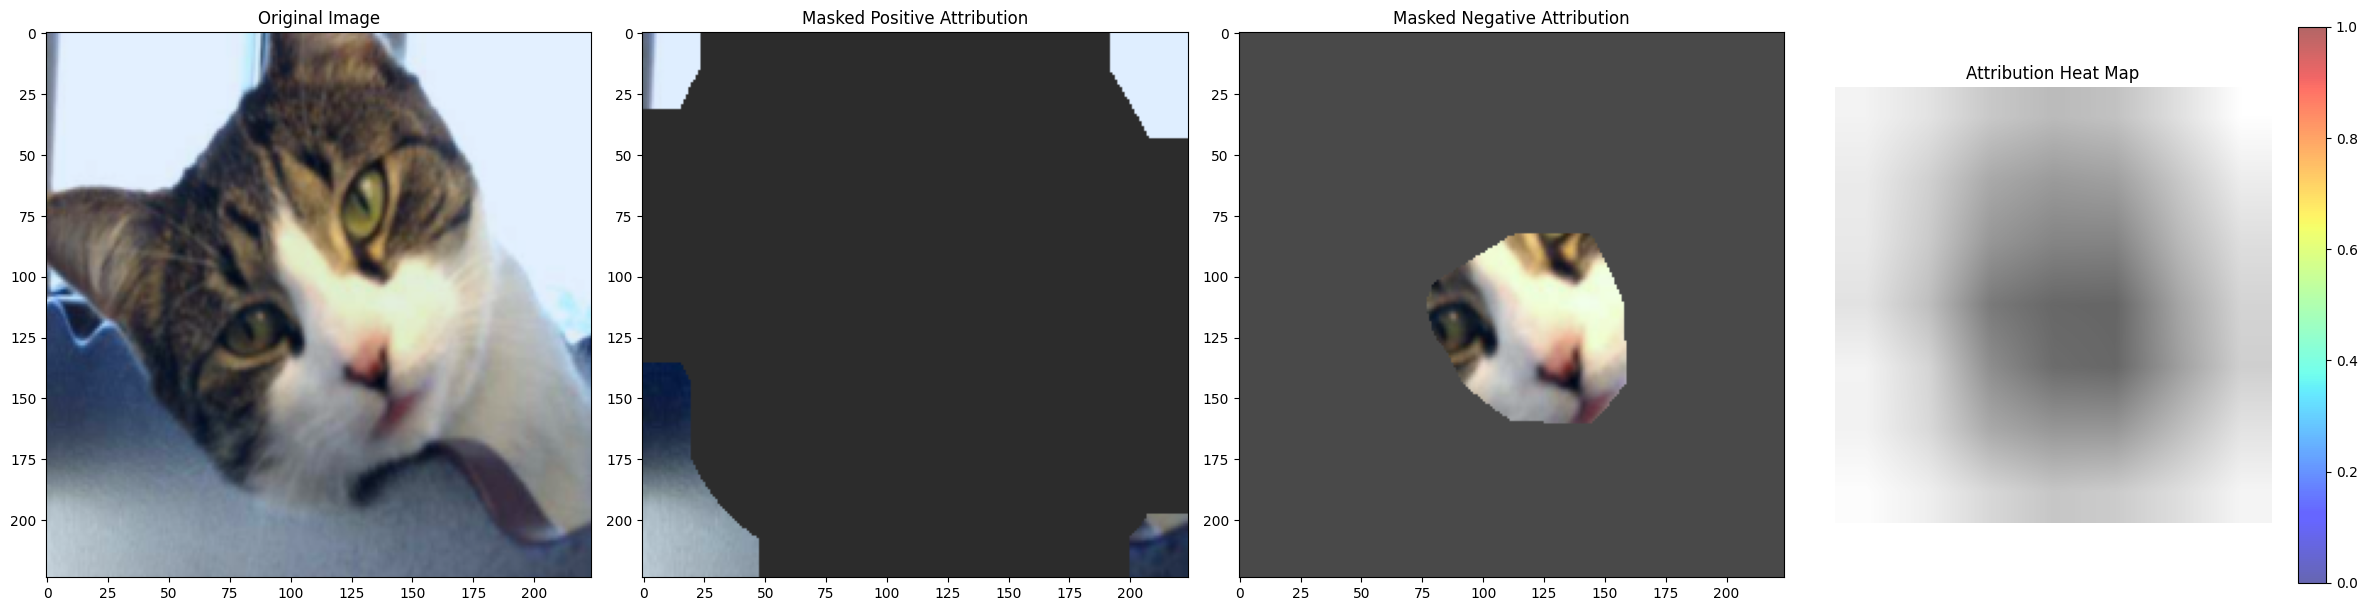

In [24]:

# Define titles for each visualization
titles = [
    "Original Image",
    "Masked Positive Attribution",
    "Masked Negative Attribution",
    "Attribution Heat Map"
]

# Create a figure for all visualizations
plt.figure(figsize=(24, 6))  # Adjust the size as needed

# Plot original and masked images
for idx, img in enumerate(images):
    plt.subplot(1, 4, idx + 1)  # 1 row, 4 columns
    plt.imshow(img)
    plt.title(titles[idx])  # Use the defined titles here

# Plot attribution heat map
plt.subplot(1, 4, 4)  # Last column for heat map
plt.imshow(heatmaps[0], cmap='jet', alpha=0.6)  # Use 'jet' or other color maps for better visibility
plt.colorbar()
plt.axis('off')
plt.title(titles[3])  # Title for heat map

plt.tight_layout()
plt.show()


<b> Doing Similarly for class 1 [ another exmaple ]</b>

# EXPLAINER ALGORITHM FOR CLASS 1 - DOG

In [25]:
sample_input, actual_label = test_dataset[0]
sample_input = sample_input.unsqueeze(0)
model.eval()
with torch.no_grad():
    output=model(sample_input)
    output = torch.sigmoid(output) 
# print(f"Model output values: {output}")
# print(f"output.item()  is:{output.item() }")
predicted_prob = output.item()
if (predicted_prob > 0.5):
    pred_label_idx=1
else:
    pred_label_idx=0

print(f"Actual Label: {actual_label.item()}")  
print(f"Predicted Label: {pred_label_idx}")  

target_tensor = pred_label_idx


Actual Label: 1.0
Predicted Label: 1


# Class 1 -Dog  - Integrated Gradients

In [26]:

integrated_gradients = IntegratedGradients(model)
try:
    attributions_ig = integrated_gradients.attribute(sample_input, target=0, n_steps=200)
    print("Attributions computed successfully.")
except Exception as e:
    print(f"Error during attribution computation: {e}")


print(f"Attributions: {attributions_ig}")

Attributions computed successfully.
Attributions: tensor([[[[ 1.8120e-03,  1.9955e-03,  9.3328e-04,  ...,  1.9884e-03,
            1.6594e-03,  7.2133e-04],
          [ 7.6120e-03,  1.4234e-02,  1.2472e-02,  ..., -5.3917e-04,
            4.5736e-03,  5.8271e-03],
          [ 5.6939e-03,  1.0370e-02,  7.6000e-03,  ...,  5.1127e-04,
           -1.9924e-03,  3.5892e-03],
          ...,
          [ 1.2200e-05, -8.1975e-07,  6.2583e-04,  ..., -1.4672e-04,
            4.6466e-04, -2.6049e-04],
          [-8.8264e-07,  1.7679e-05,  2.3290e-04,  ...,  9.8307e-04,
           -5.2346e-04, -4.2207e-07],
          [ 7.2456e-06,  4.3108e-05,  1.6956e-05,  ...,  1.0447e-04,
           -3.8881e-04, -8.5783e-05]],

         [[-8.7313e-03, -1.0644e-02, -9.6795e-03,  ...,  2.8674e-04,
           -1.5471e-03, -2.5763e-03],
          [-5.3693e-04,  7.1284e-03,  7.8807e-03,  ..., -1.8070e-03,
            2.8872e-03,  2.3267e-03],
          [ 6.1639e-04,  6.3858e-03,  5.0296e-03,  ...,  2.3577e-03,
        

# Visualisation of Dog Image(CLASS 1) after using explainer algorithm - Integrated Gradient

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.0434113].


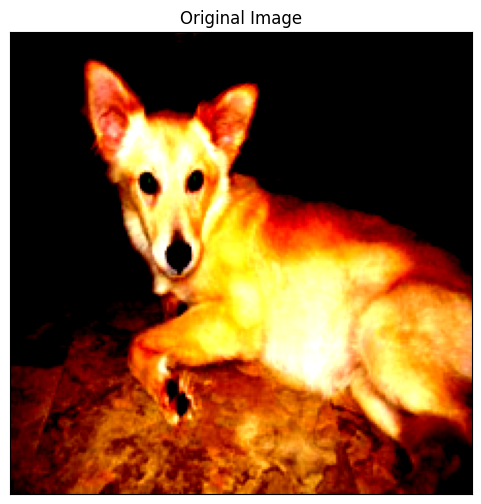

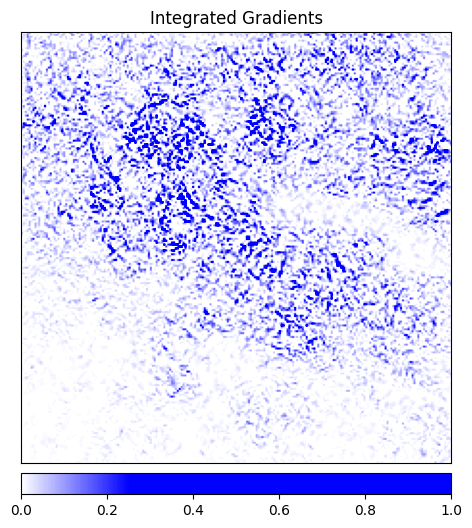

In [27]:
# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(sample_input.squeeze().cpu().detach().numpy(), (1,2,0)), 
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(sample_input.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

# CLASS 1 - DOG - GRADCAM

In [28]:

model.eval()
layers_to_visualize = [
    model.layer1[0].conv1,  
    model.layer1[1].conv2, 
    model.layer2[0].conv1,  
    model.layer2[1].conv2,  
    model.layer3[0].conv1,  
    model.layer3[1].conv2,  
    model.layer4[0].conv1,  
    model.layer4[1].conv2   
]

<Figure size 800x800 with 0 Axes>

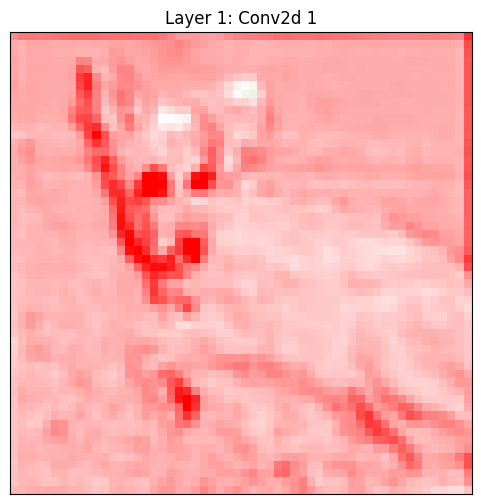

<Figure size 800x800 with 0 Axes>

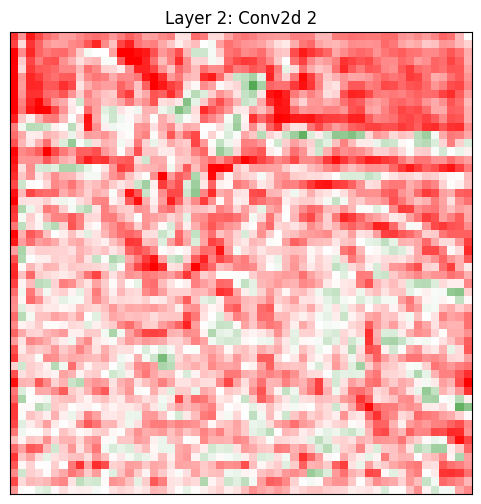

<Figure size 800x800 with 0 Axes>

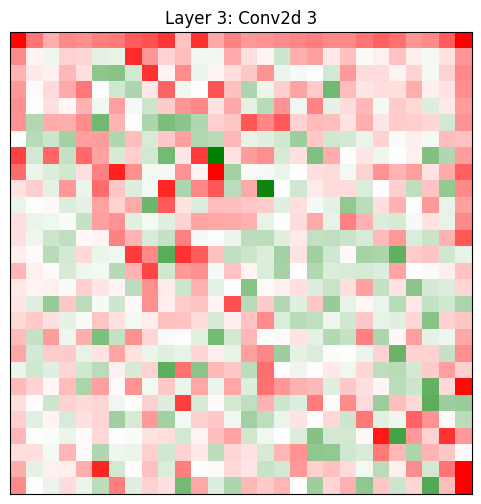

<Figure size 800x800 with 0 Axes>

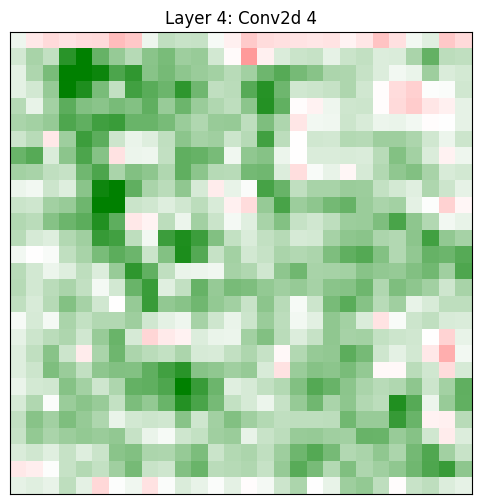

<Figure size 800x800 with 0 Axes>

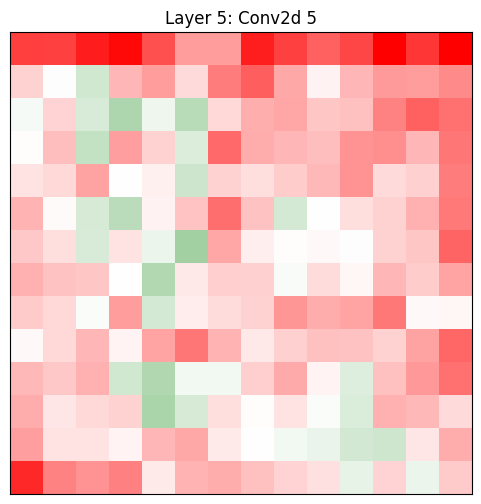

<Figure size 800x800 with 0 Axes>

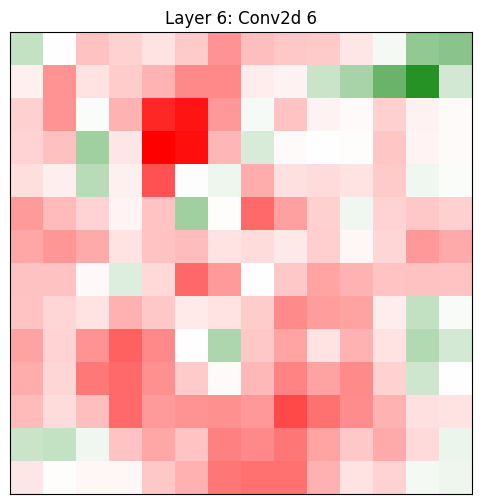

<Figure size 800x800 with 0 Axes>

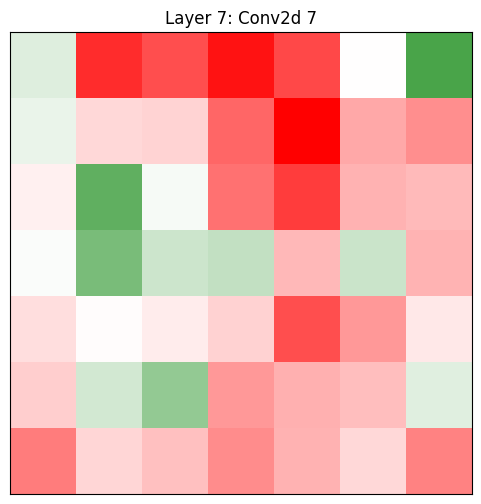

<Figure size 800x800 with 0 Axes>

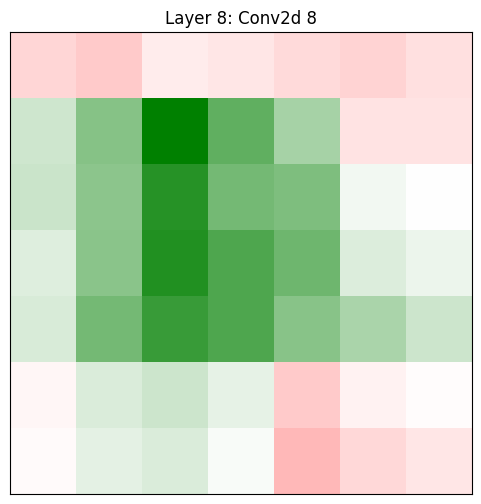

In [29]:

for i, layer in enumerate(layers_to_visualize):
    # Create LayerGradCam object for the current layer
    layer_gradcam = LayerGradCam(model, layer)

    # Get attributions for the input and target class (adjust target as needed)
    attributions_lgc = layer_gradcam.attribute(sample_input, target=0)

    # Visualize the attributions
    plt.figure(figsize=(8, 8))
    _ = viz.visualize_image_attr(
        attributions_lgc[0].cpu().permute(1, 2, 0).detach().numpy(),
        sign="all",
        title=f"Layer {i + 1}: {layer.__class__.__name__} {i + 1}"
    )
    plt.show()

In [30]:

if attributions_lgc.shape[1] == 1:  
    attributions_lgc = attributions_lgc.repeat(1, 3, 1, 1)  # Repeat the single channel 3 times to match RGB channels
elif attributions_lgc.shape[1] != 3:  # If it's not 1 or 3, this is unexpected
    raise ValueError(f"Unexpected number of channels in attributions_lgc: {attributions_lgc.shape[1]}")


In [31]:

upsamp_attr_lgc = F.interpolate(attributions_lgc, size=(224, 224), mode='bilinear', align_corners=False)

# Print shapes for debugging
print(f"Upsampled attributions shape: {upsamp_attr_lgc.shape}")  # Should be [1, 3, 224, 224]
print(f"Sample input shape: {sample_input.shape}")  # Should be [3, 224, 224]


Upsampled attributions shape: torch.Size([1, 3, 224, 224])
Sample input shape: torch.Size([1, 3, 224, 224])


In [32]:
import matplotlib.pyplot as plt
import numpy as np


if upsamp_attr_lgc.dim() == 4:  # [N, C, H, W]
    upsamp_attr_lgc = upsamp_attr_lgc.squeeze(0)  # Shape: [C, H, W]
if sample_input.dim() == 4:  # [N, C, H, W]
    sample_input = sample_input.squeeze(0)  # Shape: [C, H, W]

# Get the statistics of the attribution values
attribution_values = upsamp_attr_lgc.cpu().detach().numpy()
print(f'Min value in attribution map: {np.min(attribution_values)}')
print(f'Max value in attribution map: {np.max(attribution_values)}')
print(f'Mean value in attribution map: {np.mean(attribution_values)}')

# Use dynamic thresholds based on percentiles
positive_threshold = np.percentile(attribution_values, 90)  # 90th percentile for positive mask
negative_threshold = np.percentile(attribution_values, 10)  # 10th percentile for negative mask

print(f'Positive Mask Threshold: {positive_threshold}')
print(f'Negative Mask Threshold: {negative_threshold}')

# Create masks for positive and negative attributions
positive_mask = upsamp_attr_lgc > positive_threshold
negative_mask = upsamp_attr_lgc < negative_threshold  

# Clone the original image to apply masks without modifying it
original_image = sample_input.clone()  # Shape: [C, H, W]

# Create masked images
masked_positive_image = original_image.clone() 
masked_positive_image[~positive_mask] = 0  # Set masked positive pixels to black

masked_negative_image = original_image.clone()  
masked_negative_image[~negative_mask] = 0  # Set masked negative pixels to black

# Normalize function to scale images to [0, 1]
def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min() + 1e-8)  # Avoid division by zero

# Prepare a list for visualization with normalization
images = [
    normalize_image(original_image.permute(1, 2, 0).cpu().detach().numpy()),  # Original image
    normalize_image(masked_positive_image.permute(1, 2, 0).cpu().detach().numpy()),  # Masked positive attribution
    normalize_image(masked_negative_image.permute(1, 2, 0).cpu().detach().numpy()),  # Masked negative attribution
]

# Generate heatmaps
heatmaps = [
    normalize_image(upsamp_attr_lgc.permute(1, 2, 0).cpu().detach().numpy()),  # Attribution map
]



Min value in attribution map: -0.03401333466172218
Max value in attribution map: 0.12092334777116776
Mean value in attribution map: 0.024863913655281067
Positive Mask Threshold: 0.08011697977781296
Negative Mask Threshold: -0.015837622806429863


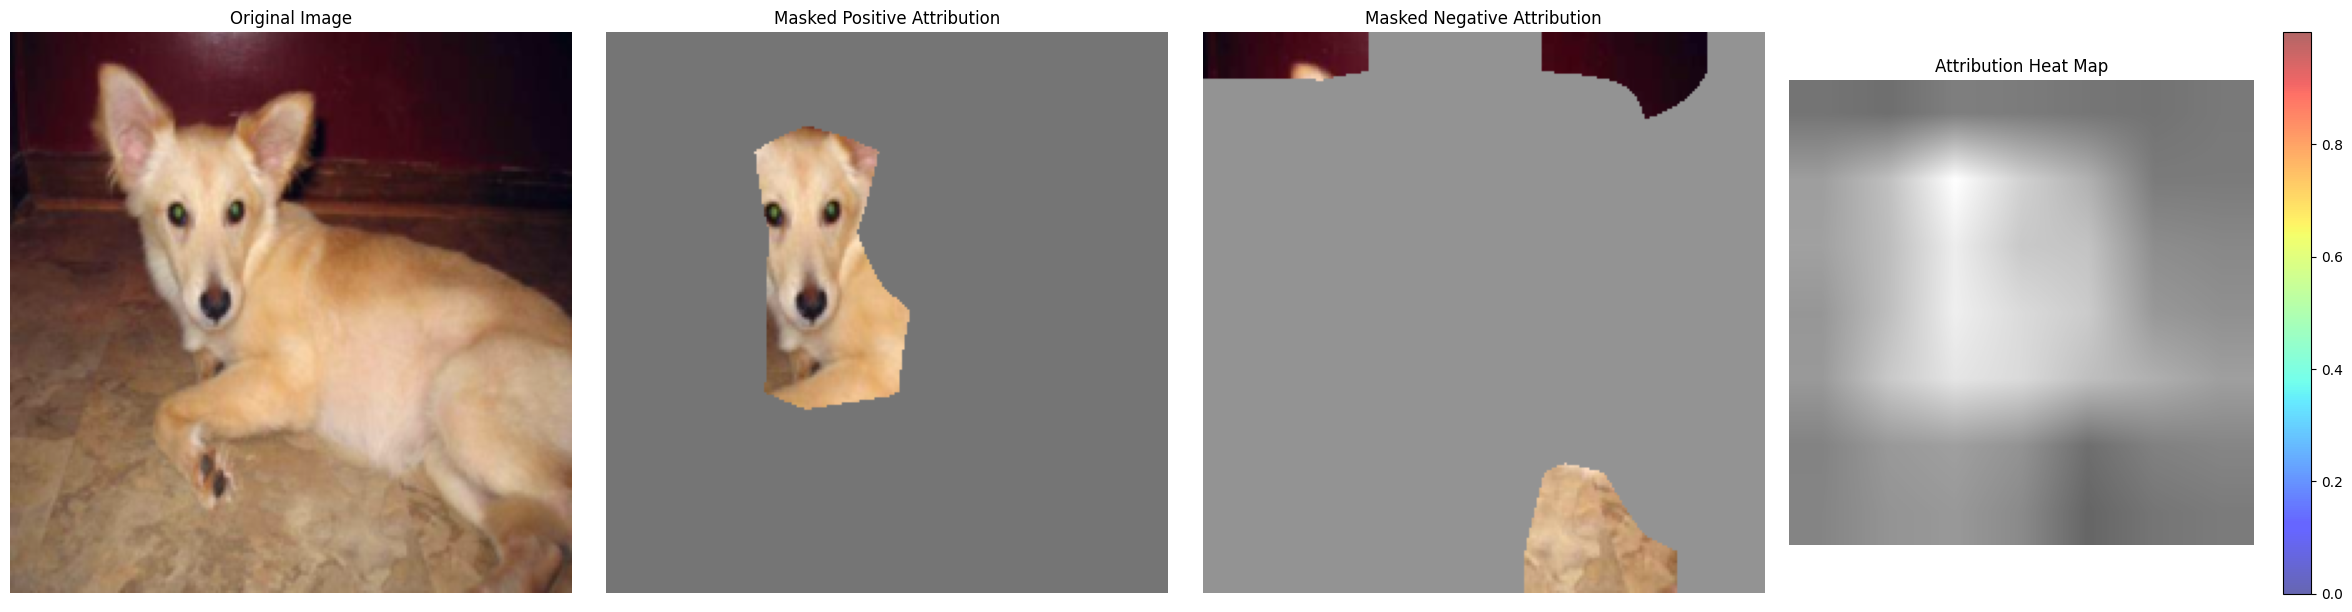

In [33]:

# Define titles for each visualization
titles = [
    "Original Image",
    "Masked Positive Attribution",
    "Masked Negative Attribution",
    "Attribution Heat Map"
]

# Create a figure for all visualizations
plt.figure(figsize=(24, 6))  # Adjust the size as needed

# Plot original and masked images
for idx, img in enumerate(images):
    plt.subplot(1, 4, idx + 1)  # 1 row, 4 columns
    plt.imshow(img)
    plt.axis('off')
    plt.title(titles[idx])  # Use the defined titles here

# Plot attribution heat map
plt.subplot(1, 4, 4)  # Last column for heat map
plt.imshow(heatmaps[0], cmap='jet', alpha=0.6)  # Use 'jet' or other color maps for better visibility
plt.colorbar()
plt.axis('off')
plt.title(titles[3])  # Title for heat map

plt.tight_layout()
plt.show()

# CAPTUM INSIGHTS - FOR BOTH CLASS 0 (CAT) AND CLASS 1(DOG)
<b>Trying to visualise for different images[first 3 from test datset] </b>


In [34]:

def baseline_func(input):
    return torch.zeros_like(input)

# Transform the images from the dataset
def full_img_transform(input):
    return input.unsqueeze(0)  


In [35]:
imgs = [test_dataset[i][0] for i in range(3)]  # Example for 3 images
labels = [test_dataset[i][1].item() for i in range(3)]  # Corresponding labels (convert to int)

In [36]:
# Apply transforms to the input images
input_imgs = torch.cat([full_img_transform(img) for img in imgs], dim=0)

<b>Idea is to create attribtion for each image , normalise them and create a heat map</b>


<b> Create a figure to display the original image and attributions</b>

In [37]:
# Initialize IntegratedGradients for attribution
ig = IntegratedGradients(model)
actual_classes =[]
predicted_class=[]
# Process each image and save the attribution visualization
for idx in range(len(imgs)):
    # Get the image and label
    sample_input = input_imgs[idx:idx + 1]  # Select the batch for the current image
    actual_label = int(labels[idx])
    predicted_class.append(F.sigmoid(model(sample_input)))
    actual_classes.append(actual_label)
    
    attributions = ig.attribute(sample_input, target=0, n_steps=50)
    # Remove batch dimension
    attributions = attributions.squeeze(0)
    
    # Convert attributions to numpy and normalize
    attributions_np = attributions.cpu().detach().numpy()
    attributions_np = (attributions_np - attributions_np.min()) / (attributions_np.max() - attributions_np.min()) 
    
    # If attributions have multiple channels, we can convert to a single channel for visualization
    if attributions_np.shape[0] == 3:  # Assuming it's in C, H, W format for RGB
        attributions_np = attributions_np.mean(axis=0)  # Convert to a single channel by averaging channels
    
    # Convert original image to PIL format for visualization
    original_image = to_pil_image(sample_input.squeeze(0))
    plt.figure(figsize=(12, 6))
    
    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')
    
    # Display attributions heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(attributions_np, cmap='hot', alpha=0.5)  # Heatmap with transparency
    plt.title("Attributions Heatmap")
    plt.axis('off')
    # Save the figure
    plt.savefig(f'attribution_visualization_{idx}.png')  # Save as an image
    plt.close()  # Close the figure to save memory
    
    print("Attribution visualizations saved successfully.")




Attribution visualizations saved successfully.
Attribution visualizations saved successfully.
Attribution visualizations saved successfully.


In [38]:
actual_classes


[1, 0, 1]

In [39]:
predicted_classes=[]
for x in predicted_class:
    if x.item()>=0.5:
        predicted_classes.append(1)
    else:
        predicted_classes.append(0)
predicted_classes

[1, 0, 1]

In [40]:
class_labels={
    0:'cat',
    1:'dog'}
actual_labels =[]
for x in predicted_classes:
    actual_labels.append(class_labels[x])
actual_labels

['dog', 'cat', 'dog']

<b> Using OS instead of rendering <b>

In [41]:

print(os.getcwd())


/Users/debikad/Desktop/AI/eng-ai-agents


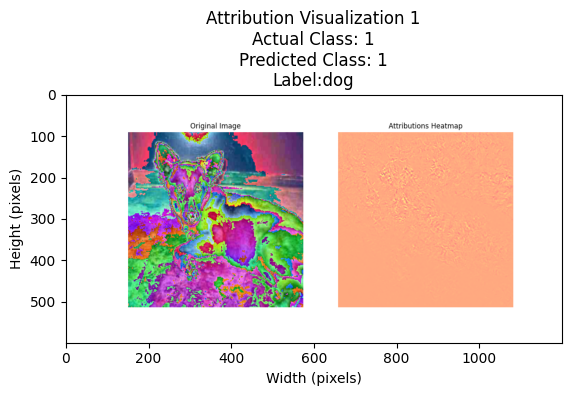

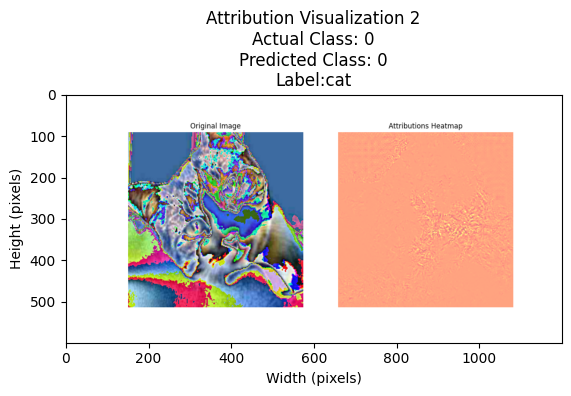

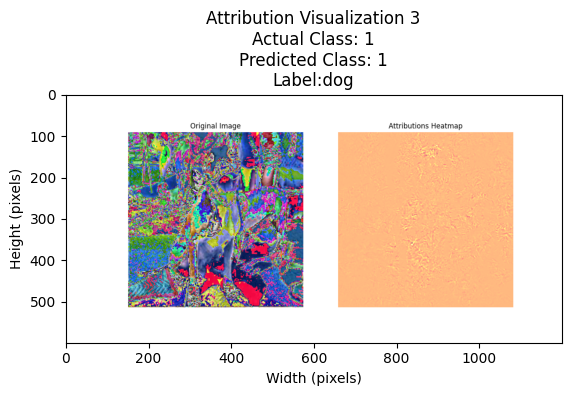

In [42]:

# Path to the saved image
for idx in range(3):
    image_path = f'/Users/debikad/Desktop/AI/eng-ai-agents/attribution_visualization_{idx}.png'
    
    # Load the image
    image = plt.imread(image_path)
    
    # Display the image
    plt.imshow(image)
    plt.xlabel("Width (pixels)")  
    plt.ylabel("Height (pixels)")  
    
    plt.title(f"Attribution Visualization {idx + 1}\n"
              f"Actual Class: {actual_classes[idx]}\n"
              f"Predicted Class: {predicted_classes[idx]}\n"
              f"Label:{actual_labels[idx]}")
    
    plt.show()
